In [20]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

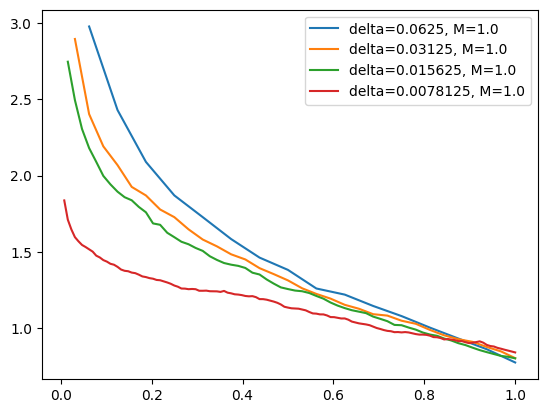

In [30]:
Ns = jnp.array([16, 32, 64, 128])
deltas = jnp.array([0.0625, 0.03125, 0.015625, 0.0078125])
fineDeltas = Ns ** 2
Mdeltas = jnp.ones((len(deltas),)) * Ns ** 0
Ndeltas = Ns
solver = "ekf0"
prefix = "BM" + solver
folder = "./"
for n in range(len(Ndeltas)):
    N = Ndeltas[n]
    delta = deltas[n]
    M = Mdeltas[n]
    fine = fineDeltas[n]
    paths_1 = jnp.load(f'{folder}/{prefix}_pathwise_sols_{N}_{M}.npy')
    paths_2 = jnp.load(f'{folder}/{prefix}_pathwise_sols2_{N}_{fine}.npy')
    N = int(N)
    N += 1
    assert N == len(paths_1[0]) == len(paths_2[0])
    ts = jnp.linspace(0, 1, N)
    ranged = range(N)
    plt.plot(ts, jnp.log(jnp.mean(jnp.linalg.norm(paths_1 - paths_2, axis=-1), axis=0)) / jnp.log(delta),
         label=f'delta={delta}, M={M}')
plt.legend()

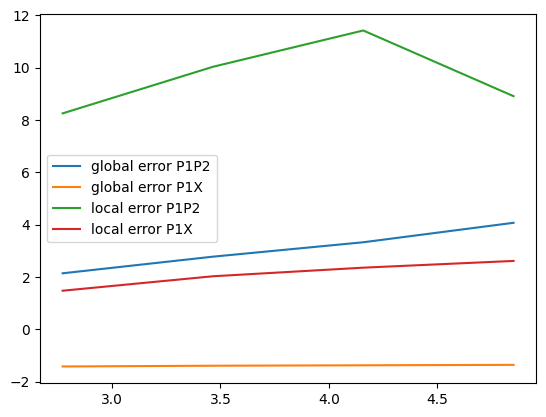

In [31]:
x0 = jnp.ones((2,))
STRONG_GLOBAL_ERRORS_P1P2 = []
STRONG_GLOBAL_ERRORS_P1X = []
STRONG_LOCAL_ERRORS_P1P2 = []
STRONG_LOCAL_ERRORS_P1X = []
for n in range(len(deltas)):
    N = Ndeltas[n]
    M = Mdeltas[n]
    fine = fineDeltas[n]
    paths_1 = jnp.load(f'{folder}/{prefix}_pathwise_sols_{N}_{M}.npy')
    paths_2 = jnp.load(f'{folder}/{prefix}_pathwise_sols2_{N}_{fine}.npy')
    paths = jnp.load(f'{folder}/{prefix}_paths_{N}_{fine}.npy')
    N = int(N)
    dt = 1 / paths.shape[1]
    k = int(paths.shape[1] / N)
    non_normalized_incs = paths * jnp.sqrt(dt)
    linspace = jnp.linspace(0, 1, N + 1)
    B = jnp.cumsum(non_normalized_incs, axis=1)
    B = jnp.insert(B, 0, 0.0, axis=1)
    V = x0[1] + B
    intB = jnp.cumsum(B, axis=1) * dt
    V = V[:, ::k, ...]
    intB = intB[:, ::k, ...]
    U = x0[0] + x0[1] * linspace[1:].reshape((linspace.shape[0] - 1)) + jnp.squeeze(intB[:, :-1], axis=-1)
    U = jnp.insert(U, 0, x0[0], axis=1)
    U = U.reshape((U.shape[0], U.shape[1],))
    V = V.reshape((V.shape[0], V.shape[1],))
    X = jnp.stack([U, V], axis=-1)
    STRONG_GLOBAL_ERROR_P1P2 = jnp.max(jnp.mean(jnp.linalg.norm(paths_2 - paths_1, axis=-1), axis=0), axis=-1)
    STRONG_GLOBAL_ERROR_P1X = jnp.max(jnp.mean(jnp.linalg.norm(paths_1 - X, axis=-1), axis=0), axis=-1)
    STRONG_LOCAL_ERROR_P1P2 = jnp.mean(jnp.linalg.norm(paths_2[:, 1] - paths_1[:, 1], axis=-1), axis=0)
    STRONG_LOCAL_ERROR_P1X = jnp.mean(jnp.linalg.norm(paths_1[:, 1] - X[:, 1], axis=-1), axis=0)
    STRONG_GLOBAL_ERRORS_P1P2.append(STRONG_GLOBAL_ERROR_P1P2)
    STRONG_GLOBAL_ERRORS_P1X.append(STRONG_GLOBAL_ERROR_P1X)
    STRONG_LOCAL_ERRORS_P1P2.append(STRONG_LOCAL_ERROR_P1P2)
    STRONG_LOCAL_ERRORS_P1X.append(STRONG_LOCAL_ERROR_P1X)
STRONG_GLOBAL_ERRORS_P1P2 = jnp.array(STRONG_GLOBAL_ERRORS_P1P2)
STRONG_GLOBAL_ERRORS_P1X = jnp.array(STRONG_GLOBAL_ERRORS_P1X)
STRONG_LOCAL_ERRORS_P1P2 = jnp.array(STRONG_LOCAL_ERRORS_P1P2)
STRONG_LOCAL_ERRORS_P1X = jnp.array(STRONG_LOCAL_ERRORS_P1X)
plt.plot(-jnp.log(deltas), -jnp.log(STRONG_GLOBAL_ERRORS_P1P2), label='global error P1P2')
plt.plot(-jnp.log(deltas), -jnp.log(STRONG_GLOBAL_ERRORS_P1X), label='global error P1X')
plt.plot(-jnp.log(deltas), -jnp.log(STRONG_LOCAL_ERRORS_P1P2), label='local error P1P2')
plt.plot(-jnp.log(deltas), -jnp.log(STRONG_LOCAL_ERRORS_P1X), label='local error P1X')
plt.legend()

In [32]:
linear_regressor = LinearRegression().fit(-jnp.log(deltas).reshape(-1, 1), -jnp.log(STRONG_GLOBAL_ERRORS_P1P2))
print(linear_regressor.coef_)
print(linear_regressor.score(-jnp.log(deltas).reshape(-1, 1), -jnp.log(STRONG_GLOBAL_ERRORS_P1P2)))
linear_regressor = LinearRegression().fit(-jnp.log(deltas).reshape(-1, 1), -jnp.log(STRONG_LOCAL_ERRORS_P1P2))
print(linear_regressor.coef_)
print(linear_regressor.score(-jnp.log(deltas).reshape(-1, 1), -jnp.log(STRONG_LOCAL_ERRORS_P1P2)))
linear_regressor = LinearRegression().fit(-jnp.log(deltas).reshape(-1, 1), -jnp.log(STRONG_GLOBAL_ERRORS_P1X))
print(linear_regressor.coef_)
linear_regressor = LinearRegression().fit(-jnp.log(deltas).reshape(-1, 1), -jnp.log(STRONG_LOCAL_ERRORS_P1X))
print(linear_regressor.coef_)


[0.9146005]
0.996614870402411
[0.48444945]
0.09750130018410086
[0.02923439]
[0.5399457]


In [19]:
paths_1

Array([[[1.0000000e+00],
        [1.3836594e+00],
        [1.4414902e+00],
        ...,
        [          nan],
        [          nan],
        [          nan]],

       [[1.0000000e+00],
        [1.3637137e+00],
        [1.2970209e+00],
        ...,
        [          nan],
        [          nan],
        [          nan]],

       [[1.0000000e+00],
        [1.0665077e+00],
        [1.3517202e+00],
        ...,
        [          nan],
        [          nan],
        [          nan]],

       ...,

       [[1.0000000e+00],
        [1.0513400e+00],
        [9.8262817e-01],
        ...,
        [2.8682533e+01],
        [9.3035027e+01],
        [2.3692822e+03]],

       [[1.0000000e+00],
        [1.0311567e+00],
        [9.4466519e-01],
        ...,
        [1.0451731e+03],
        [1.9426964e+07],
        [2.1734084e+24]],

       [[1.0000000e+00],
        [1.0139847e+00],
        [1.3141721e+00],
        ...,
        [2.7765493e+11],
        [          inf],
        [          nan]]

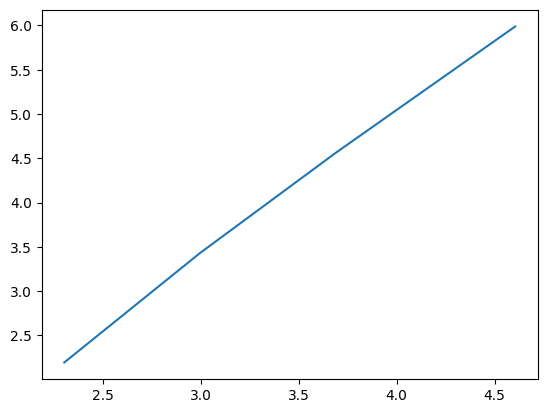

In [13]:
deltas = [0.1, 0.05, 0.025, 0.01]
LOCAL_ERRORS = []
for delta in deltas:
    experiment_local = jnp.load(f'./experiment_{delta}.npy')
    LOCAL_ERRORS.append(jnp.mean(jnp.linalg.norm(experiment_local[0]-experiment_local[1], axis=-1), axis=0))
LOCAL_ERRORS = jnp.array(LOCAL_ERRORS)
deltas = jnp.array(deltas)
plt.plot(-jnp.log(deltas), -jnp.log(LOCAL_ERRORS))

In [14]:
linear_regressor = LinearRegression().fit(-jnp.log(deltas).reshape(-1, 1), -jnp.log(LOCAL_ERRORS))
print(linear_regressor.coef_)

[1.6431799]


In [12]:
LOCAL_ERRORS

Array([0.05534366, 0.01586504, 0.00515722, 0.00124821], dtype=float32)